In [1]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Input, Flatten, MaxPool2D, Dropout, Lambda
from tensorflow.keras.utils import plot_model 
import matplotlib.pyplot as plt
import numpy as np

In [60]:
#@title Choose Dataset {run : "auto"}
DS = "MNIST" #@param ["MNIST", "Fashion MNIST"]

if DS == "MNIST":
  (dataset), (dataset_test) = tf.keras.datasets.mnist.load_data() 
  class_names = list(map(str, np.arange(0, 10)))
  Labels = ["Odd", "Even"]
else:
  (dataset), (dataset_test) = tf.keras.datasets.fashion_mnist.load_data()
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  Labels = ["Lower", "Upper"]


11493376/11490434 [==============================] - 0s 0us/step


In [62]:
# Check shapes of Loaded Data
print(DS +  ": Training Images = %s, Training Labels = %s, Test Images = %s, Test Labels = %s" % (dataset[0].shape, dataset[1].shape,\
                                                                                                dataset_test[0].shape, dataset_test[1].shape))

MNIST: Training Images = (60000, 28, 28), Training Labels = (60000,), Test Images = (10000, 28, 28), Test Labels = (10000,)


In [0]:
# Preprocess Input
dataset_y_2 = (dataset[1] % 2 == 0).astype(np.uint8) # Convert even numbers to 1 and odd to zero
dataset_ty_2 = (dataset_test[1] % 2 == 0).astype(np.uint8)
dataset_x = dataset[0][:,:,:,np.newaxis]/255.0 # Normalise images
dataset_tx = dataset_test[0][:,:,:,np.newaxis]/255.0
dataset_y = dataset[1]
dataset_ty = dataset_test[1]

# Check shapes
assert dataset_tx.shape == (10000, 28, 28, 1)
assert dataset_x.shape == (60000, 28, 28, 1)
assert dataset_tx.shape == (10000, 28, 28, 1)
assert dataset_x.shape == (60000, 28, 28, 1)
assert dataset_y.shape == (60000,)
assert dataset_ty.shape == (10000,)
assert dataset_y_2.shape == (60000,)
assert dataset_ty_2.shape == (10000,)

In [66]:

# Define Model
inp = Input(shape = (28, 28, 1))
conv_layer_1 = Conv2D(8, (3,3), padding = 'same', activation = 'relu')(inp)
conv_layer_2 = Conv2D(8, (1,1), activation = 'relu')(conv_layer_1)

# Dividing for type
x = Conv2D(16, (5,5), activation = 'relu')(conv_layer_2)
x = MaxPool2D()(x)
x = Conv2D(16, (5,5), activation = 'relu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation = 'relu')(x)
output_1 = Dense(1, activation = 'sigmoid', name = 'Label_Output')(x)

# Dividing for type
y = Conv2D(16, (3,3), activation = 'relu')(conv_layer_2)
y = Conv2D(16, (3,3), activation = 'relu')(y)
y = MaxPool2D()(y)
y = Conv2D(32, (3,3), activation = 'relu')(y)
y = MaxPool2D()(y)
y = Flatten()(y)
y = Dropout(0.2)(y)
y = Dense(64, activation = 'relu')(y)
output_2 = Dense(10, activation = 'softmax', name = 'Category_Output')(y)

model = Model(inputs = [inp], outputs = [output_1, output_2])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 8)    80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 8)    72          conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 26, 26, 16)   1168        conv2d_8[0][0]                   
____________________________________________________________________________________________

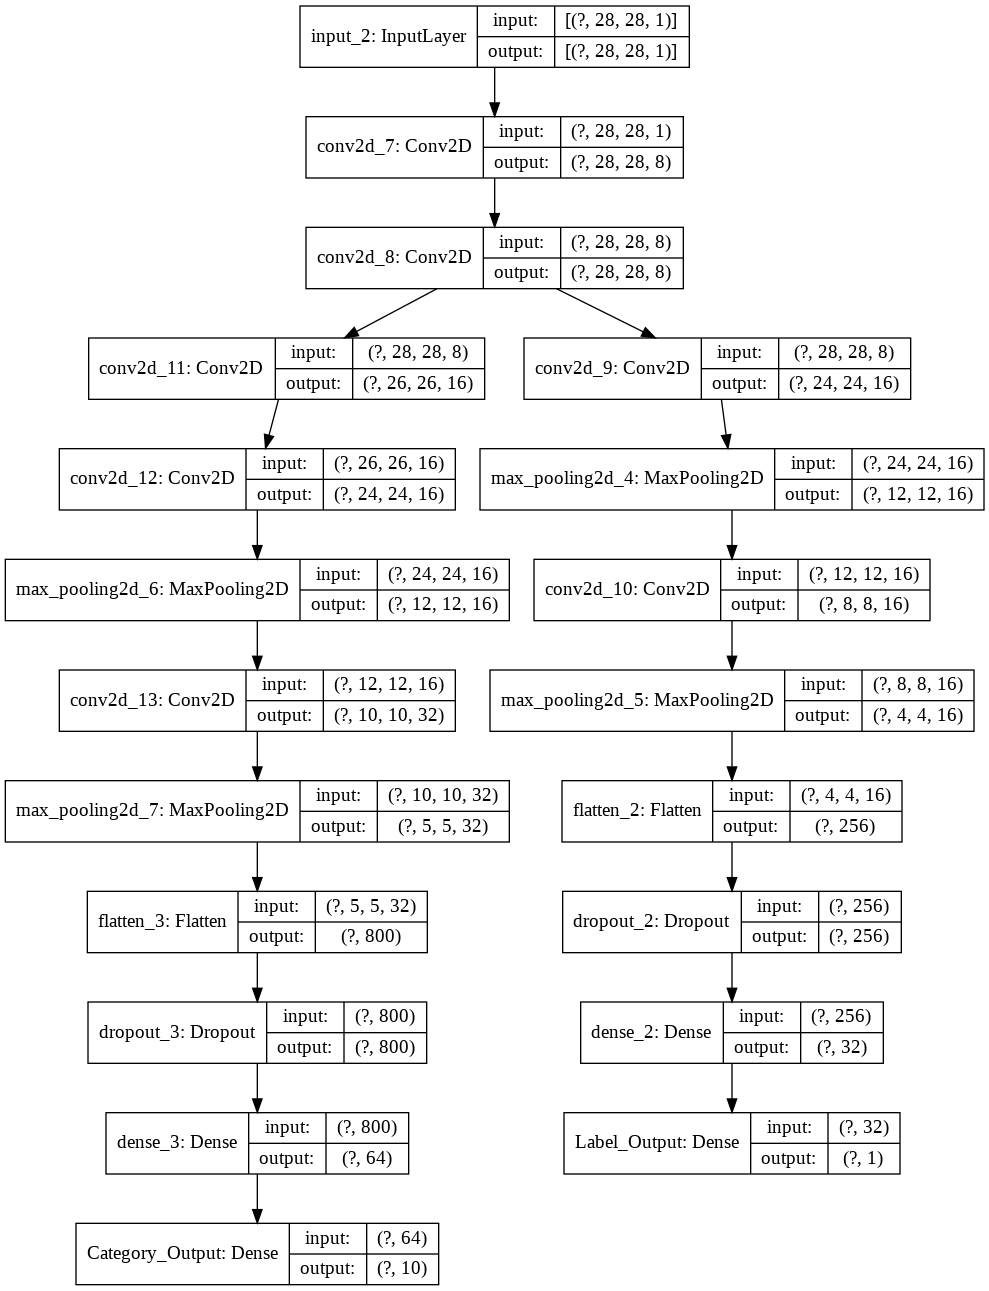

In [67]:
# Plot model graph
plot_model(model, show_shapes = True)

In [0]:
# Compile Model
losses = {
	"Label_Output": "binary_crossentropy",
	"Category_Output": "sparse_categorical_crossentropy",
}
lossWeights = {"Label_Output": 1.0, "Category_Output": 1.0}

model.compile(optimizer= 'sgd', loss = losses, loss_weights=lossWeights, metrics = ['accuracy'])

In [69]:
# Fit Model
epoch = 20
batch_size = 32

H = model.fit(
    dataset_x,
    {"Label_Output": dataset_y_2, "Category_Output": dataset_y},
    batch_size = batch_size,
    epochs = epoch,
    verbose = 1,
    validation_data = (dataset_tx, 
                       {"Label_Output": dataset_ty_2, "Category_Output": dataset_ty}
                       )
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 23s 381us/sample - loss: 0.9597 - Label_Output_loss: 0.2885 - Category_Output_loss: 0.6712 - Label_Output_acc: 0.8718 - Category_Output_acc: 0.7780 - val_loss: 0.2000 - val_Label_Output_loss: 0.0869 - val_Category_Output_loss: 0.1133 - val_Label_Output_acc: 0.9691 - val_Category_Output_acc: 0.9650
Epoch 2/20
60000/60000 [==============================] - 22s 368us/sample - loss: 0.2247 - Label_Output_loss: 0.0955 - Category_Output_loss: 0.1292 - Label_Output_acc: 0.9659 - Category_Output_acc: 0.9600 - val_loss: 0.1219 - val_Label_Output_loss: 0.0464 - val_Category_Output_loss: 0.0760 - val_Label_Output_acc: 0.9844 - val_Category_Output_acc: 0.9762
Epoch 3/20
60000/60000 [==============================] - 22s 366us/sample - loss: 0.1617 - Label_Output_loss: 0.0679 - Category_Output_loss: 0.0938 - Label_Output_acc: 0.9761 - Category_Output_acc: 0.9713 - val_loss: 0.0860 - val_Label

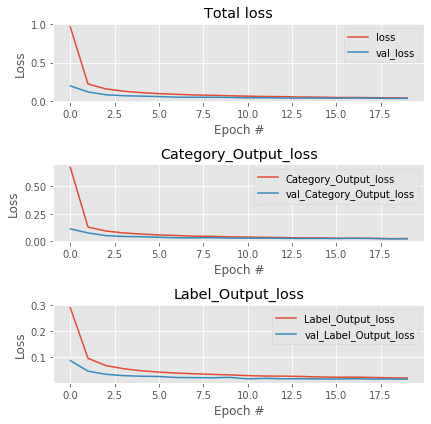

In [70]:
# Adapted from https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

# plot the total loss, category loss, and color loss
lossNames = ["loss", "Category_Output_loss", "Label_Output_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(6, 6))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = l if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(np.arange(0, epoch), H.history[l], label=l)
	ax[i].plot(np.arange(0, epoch), H.history["val_" + l],
		label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()


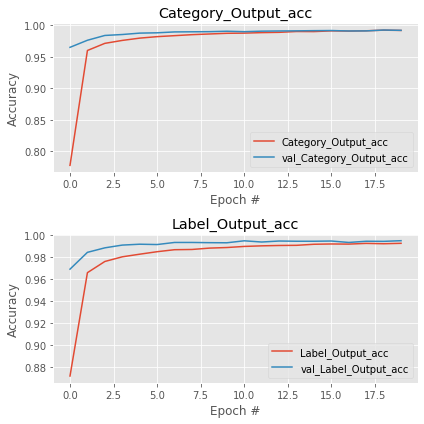

In [71]:
# Adapted from https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

# create a new figure for the accuracies
accuracyNames = ["Category_Output_acc", "Label_Output_acc"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots( 2, 1, figsize=( 6, 6))
# loop over the accuracy names
for (i, l) in enumerate(accuracyNames):
	# plot the loss for both the training and validation data
	ax[i].set_title(l)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Accuracy")
	ax[i].plot(np.arange(0, epoch), H.history[l], label=l)
	ax[i].plot(np.arange(0, epoch), H.history["val_" + l],
		label="val_" + l)
	ax[i].legend()
# save the accuracies figure
plt.tight_layout()

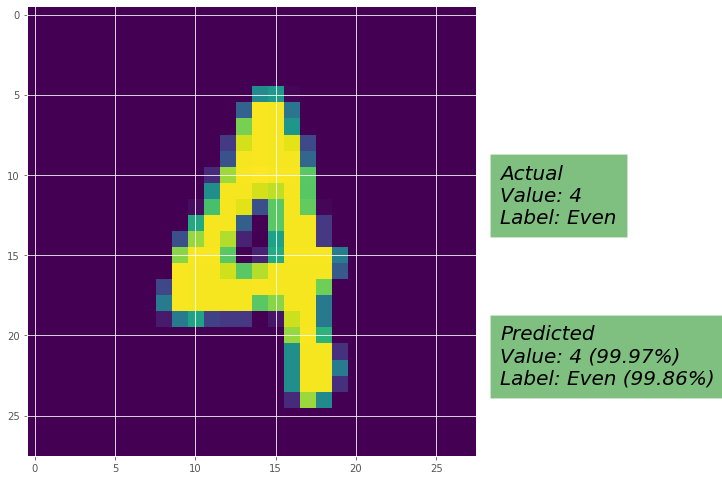

In [86]:
#@title Visualise test outputs { run: "auto" }
img_num = 1989 #@param {type:"slider", min:0, max:10000, step:1}
img = dataset_tx[img_num].squeeze() 
pred = model.predict(img.reshape(1,28,28,1))

LblVal = int(np.round(pred[0].squeeze()))

Lbl = Labels[LblVal]
Val = class_names[pred[1].argmax()]

LblProb = pred[0].squeeze() if LblVal==1 else  (1 - pred[0].squeeze())
ValProb = pred[1].max()

NumText = "Value: {} ({:.2f}%)".format(Val,
	ValProb * 100)
LblText = "Label: {} ({:.2f}%)".format(Lbl,
	LblProb * 100)

colour = 'green' if (pred[1].argmax() == dataset_ty[img_num] and\
                     LblVal ==  dataset_ty_2[img_num]) else 'red'

plt.figure(figsize = (10,10))
plt.imshow(img)

plt.text(29, 13, "Actual\n" + "Value: " + class_names[dataset_ty[img_num]] +\
         "\n" + "Label: " + Labels[dataset_ty_2[img_num]], style='italic', size = 20,\
         bbox={'facecolor': "green", 'alpha': 0.5, 'pad': 10})

plt.text(29, 23, "Predicted\n" + NumText + "\n" + LblText, style='italic', size = 20,\
         bbox={'facecolor': colour, 'alpha': 0.5, 'pad': 10})

plt.tight_layout()